<a id="top"></a>
# Pendule élastique - Section de Poincaré - Diagramme de bifurcation

<div style="text-align:center;margin-right:10%;">
<img style="max-width:350px;" src="attachment:pendule_elastique.png" alt="Pendule élastique" />
</div>

Les équations de mouvement adimensionnées de ce pendule sont données par : <br>
$ \hspace{0.5cm} 
\begin{cases} 
\rho \ddot \theta + 2 \dot\rho\dot\theta + 2\epsilon_2\omega_2\dot\theta + \omega_2^2 sin(\theta)= \dfrac{sin(\theta)}{l_0}\ddot\lambda \\ 
\ddot\rho-\rho\dot\theta^2 +2 \epsilon_1 \omega_1 \dot\rho + \omega_1^2 \left(\rho-1\right) - \omega_2^2 cos(\theta) = -\dfrac{cos(\theta)}{l_0}\ddot\lambda  
\end{cases} 
\hspace{0.5cm}$ avec $ \hspace{0.5cm} \omega_1^2 = \dfrac{k}{M} \hspace{0.25cm}$ et $ \hspace{0.25cm}\omega_2^2 = \dfrac{g}{l_0}$

<br>
que l'on peut réécrire sous la forme matricielle suivante :<br>
$$
\left[ \begin{array}{cc}
1&0\\
0&1
\end{array} \right]
\left( \begin{array}{cc}
{\ddot \rho }\\
{\ddot \theta }
\end{array} \right)
+
\left[ \begin{array}{cc}
2\varepsilon_1\omega_1&0\\
0&0
\end{array} \right]
\left( \begin{array}{cc}
{\dot \rho }\\
{\dot \theta }
\end{array} \right)
+
\left[ \begin{array}{cc}
\omega_1^2&0\\
0&0
\end{array} \right]
\left( \begin{array}{cc}
{\rho }\\
{\theta }
\end{array} \right)
+ 
\left( \begin{array}{c}
 - \rho \,{{\dot \theta }^2} - \cos\theta \left(\omega_2^2- \frac{\ddot \lambda(t)}{l_0}\right) - \omega_1^2\\
\frac{1}{\rho }\left[ 2\dot\rho\dot\theta + 2\varepsilon_1\omega_2\,\dot \theta  + \sin\theta \left(\omega_2^2  - \frac{\ddot \lambda(t)}{l_0}\right) \right]
\end{array} \right) = 0
$$

<br>
C'est un système différentiel non linéaire du 2nd ordre de la forme : <br>

$$
M\,\ddot x(t) + C\,\dot x(t) + K\,x(t) + f_{nl}(x,\dot x) = p(t)
$$
<br>
avec 
$$
x(t)=\begin{pmatrix}
\rho\\
\theta
\end{pmatrix}
\quad
M=\left[ \begin{array}{cc}
1&0\\
0&1
\end{array} \right]
\quad
C=\left[ \begin{array}{cc}
2\varepsilon_1\omega_1&0\\
0&0
\end{array} \right]
\quad
K=\left[ \begin{array}{cc}
\omega_1^2&0\\
0&0
\end{array} \right]
$$

$$
f_{nl}(x,\dot x)=
\begin{pmatrix} f_{nl1} \\ f_{nl2} \end{pmatrix}
=\left( \begin{array}{c}
 - \rho \,{{\dot \theta }^2} - \cos\theta \left(\omega_2^2- \frac{\ddot \lambda(t)}{l_0}\right) - \omega_1^2\\
\frac{1}{\rho }\left[ 2\dot\rho\dot\theta + 2\varepsilon_1\omega_2\,\dot \theta  + \sin\theta \left(\omega_2^2  - \frac{\ddot \lambda(t)}{l_0}\right) \right]
\end{array} \right)
$$


[Résolution avec solve_ivp de Scipy](#solve_ivp) |
[Algorithme de Newmark](#Newmark) |
[Trajectoire du pendule](#Trajectoire) |
[Animation et portraits de phase](#Animation)  |
[Sections de Poincaré](#Poincare)  |
[Diagramme de bifurcation](#Diagramme)<br>
---

## Mise en place des paramètres

In [1]:
# import des librairies additionnelles
import numpy as np
from numpy import zeros,eye
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import solve_ivp, odeint
import time
%matplotlib notebook


In [2]:
# paramètres
# accélération pesanteur g (m.s^-2), longueur à vide du ressort l0 (m), masse M (kg) du pendule, 
# raideur du ressort k (N/m) et facteurs d'amortissement
#
g=9.81; M=0.02; l0=0.6; k=0.5; 
#epsilon1=0.002; epsilon2=0.003;
epsilon1=0.03; epsilon2=0.02;
#
# pulsations et fréquences utilisées pour adimensionner le système d'équation de movement 
omega1 = np.sqrt(k/M); f1 = omega1/(2*np.pi);
omega2 = np.sqrt(g/l0); f2 = omega2/(2*np.pi);
#
# caractéristiques de l'excitation : plusation et amplitude
#omega = (omega1 + omega2) / 2 ; 
omega=omega2*5/4;
T = 2*np.pi/omega
#a=0.0    # sol amortie
a=0.015  # periodique
#a=0.0215 # periodique 2T
#a=0.039  # chaotique
#a=0.12   # 2T-periodique en theta
#
# durée de simulation = Np périodes de l'excitation avec Ni points d'intégration par période
Np=40; Ni=100
NT=Np*Ni+1
# temps initial t0, final tf, pas de temps dt et vecteur temps de simulation
t0=0; tf=Np*T
dt=T/Ni
t_balayage = np.linspace(t0, tf, NT)
# positions et vitesses initiales
theta0=0.; dtheta0=0.1; rho0=1.; drho0=0.


---
<a id="solve_ivp"></a>
## Résolution par solve_ivp (schéma RK45) de Scipy pour avoir une solution de référence
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>
$ \hspace{0.5cm} 
\begin{cases} 
\rho \ddot \theta =- 2 \dot\rho\dot\theta - 2\epsilon_2\omega_2\dot\theta - sin(\theta)\left(\omega_2^2  -\dfrac{\ddot\lambda}{l_0} \right) \\ 
\ddot\rho=\rho\dot\theta^2 -2 \epsilon_1 \omega_1 \dot\rho - \omega_1^2 \left(\rho-1\right) + cos(\theta)\left(\omega_2^2  -\dfrac{\ddot\lambda}{l_0} \right) 
\end{cases} 
$


In [3]:
def Pendule_elastique(t,X):
    theta, dtheta, rho, drho = X
    ddlambda=-a*omega**2*np.sin(omega*t)
    dthetadt = dtheta
    ddthetadt = -(2*drho*dtheta+2*epsilon2*omega2*dtheta+np.sin(theta)*(omega2**2-ddlambda/l0))/rho
    drhodt = drho
    ddrhodt = rho*dtheta**2-2*epsilon1*omega1*drho-omega1**2*(rho-1)+np.cos(theta)*(omega2**2-ddlambda/l0)
    return [dthetadt, ddthetadt, drhodt, ddrhodt]

In [4]:
x0=[theta0,dtheta0,rho0,drho0];
#
start = time.process_time()
sol=solve_ivp(Pendule_elastique, [t0,tf], x0, method='RK45', t_eval=t_balayage, rtol=1e-9, atol=1e-9)
print('ellapsed time: ',time.process_time() - start)
#solodeint = odeint(Pendule_elastique, x0, t_balayage, tfirst=True)

ellapsed time:  0.375


---
<a id="Newmark"></a>
## Définition des fonctions non-linéaires pour Newmark
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>
$$
f_{nl}(x,\dot x)=
\begin{pmatrix} f_{nl1} \\ f_{nl2} \end{pmatrix}
=\left( \begin{array}{c}
 - \rho \,{{\dot \theta }^2} - \cos\theta \left(\omega_2^2- \frac{\ddot \lambda(t)}{l_0}\right) - \omega_1^2\\
\frac{1}{\rho }\left[ 2\dot\rho\dot\theta + 2\varepsilon_1\omega_2\,\dot \theta  + \sin\theta \left(\omega_2^2  - \frac{\ddot \lambda(t)}{l_0}\right) \right]
\end{array} \right)
$$

$$
\frac{\partial f_{nl}}{\partial x} 
= \left( \begin{array}{cc}
\frac{\partial f_{nl1}}{\partial \rho}&\frac{\partial f_{nl1}}{\partial \theta}\\
\frac{\partial f_{nl2}}{\partial \rho}&\frac{\partial f_{nl2}}{\partial \theta}
\end{array} \right) 
= \left( \begin{array}{cc}
 - {\dot \theta }^2 & \sin\theta \left(\omega_2^2- \frac{\ddot \lambda(t)}{l_0}\right)\\
 - \frac{1}{\rho ^2}\left[ 2\dot\rho\dot\theta + 2\varepsilon_1\omega_2\,\dot \theta  + \sin\theta \left(\omega_2^2  - \frac{\ddot \lambda(t)}{l_0}\right) \right] &\frac{1}{\rho}\cos\theta \left(\omega_2^2  - \frac{\ddot \lambda(t)}{l_0}\right)
\end{array} \right)
$$

$$
\frac{{\partial {f_{nl}}}}{{\partial \dot x}} = \left( {\begin{array}{*{20}{c}}
{\frac{{\partial {f_{nl1}}}}{{\partial \dot \rho }}}&{\frac{{\partial {f_{nl1}}}}{{\partial \dot \theta }}}\\
{\frac{{\partial {f_{nl2}}}}{{\partial \dot \rho }}}&{\frac{{\partial {f_{nl2}}}}{{\partial \dot \theta }}}
\end{array}} \right) = \left( {\begin{array}{*{20}{c}}
{2\,{\varepsilon _{\,1}}\,{\omega _{\,1}}}&{ - 2\rho \,\dot \theta }\\
{\frac{1}{\rho }2\,\dot \theta }&{\,\,\,\frac{1}{\rho }\left( {2\,\dot \rho \, + 2\,{\varepsilon _{\,2}}\,{\omega _{\,2}}} \right)}
\end{array}} \right)
$$

In [5]:
def calc_P(p0,OMEGA,t):
    P=zeros((ndof,1))
    return P

def calc_Fnl(X,dX,t):
    rho,theta=X
    drho,dtheta=dX
    ddlambda=-a*omega**2*np.sin(omega*t)
    Fnl=zeros((ndof,1))
    Fnl[0]=-rho*dtheta**2-np.cos(theta)*(omega2**2-ddlambda/l0)-omega1**2
    Fnl[1]=(2*drho*dtheta+2*epsilon2*omega2*dtheta+np.sin(theta)*(omega2**2-ddlambda/l0))/rho
    return Fnl

def calc_dFnl(X,dX,t):
    rho,theta=X
    drho,dtheta=dX
    ddlambda=-a*omega**2*np.sin(omega*t)
    dFX=zeros((ndof,ndof))
    dFdX=zeros((ndof,ndof))
    # dF/dX
    dFX[0,0]=-dtheta**2
    dFX[0,1]=np.sin(theta)*(omega2**2-ddlambda/l0)
    dFX[1,0]=-(2*drho*dtheta+2*epsilon2*omega2*dtheta+np.sin(theta)*(omega2**2-ddlambda/l0))/(rho**2)
    dFX[1,1]=np.cos(theta)*(omega2**2-ddlambda/l0)/rho
    # dF/d(dX)
    dFdX[0,0]=0
    dFdX[0,1]=-2*rho*dtheta
    dFdX[1,0]=2*dtheta/rho
    dFdX[1,1]=(2*drho+2*epsilon2*omega2)/rho
    return dFX,dFdX

## Algorithme de Newmark

In [6]:
def Newmark(X0,dX0,t_init,dt,NT):
    precNR=1e-9
    # sol initiale
    t=t_init
    X=X0;dX=dX0
    # initialisation des vecteurs et matrices
    Fnl=zeros((ndof,1))
    dFX=zeros((ndof,ndof))
    dFdX=zeros((ndof,ndof))
    P=zeros((ndof,1));
    tt=zeros((NT,1))
    Xt=zeros((NT,ndof))
    dXt=zeros((NT,ndof))
    
    P=calc_P(p0,omega,t)
    Fnl=calc_Fnl(X,dX,t)
    ddX=np.linalg.solve(M, P-C@dX-K@X-Fnl)  # @ = raccourci pour np.matmul, * = multiplication elt par elt
    tt[0]=t
    Xt[0,:]=X[:,0]
    dXt[0,:]=dX[:,0]
    
    # Boucle sur les pas de temps
    for n in range(1,NT):
        t+=dt
        # prediction
        iter=0;
        X=X+dt*dX+(dt**2/2)*ddX
        dX=dX+dt*ddX
        ddX=ddX
        # Calcul du residu
        P=calc_P(p0,omega,t)
        Fnl=calc_Fnl(X,dX,t)
        res=P-M@ddX-C@dX-K@X-Fnl
        #normres=linalg.norm(res)/linalg.norm(P)
        normres=10*precNR
        # Corrections Newton Raphson
        while (normres>precNR):
            iter+=1
            # Calcul de la Jacobienne
            dFX,dFdX=calc_dFnl(X,dX,t)
            J=(4/dt**2)*M+(2/dt)*(C+dFdX)+K+dFX
            # Calcul de la correction
            deltaX=np.linalg.solve(J,res)
            X=X+deltaX
            dX=dX+(2/dt)*deltaX
            ddX=ddX+(4/dt**2)*deltaX
            # Calcul du residu
            Fnl=calc_Fnl(X,dX,t)
            res=P-M@ddX-C@dX-K@X-Fnl
            #normres=linalg.norm(res)/linalg.norm(P)
            normres=np.linalg.norm(deltaX)/np.linalg.norm(X)
        tt[n]=t
        Xt[n,:]=X[:,0]
        dXt[n,:]=dX[:,0]
#        if t>5.5:
#            print('t=',t,'  X=',X[:,0],'  iter=',iter)
#            input("Press Enter to continue...")        
    return tt,Xt,dXt

### Résolution des équations du mouvement par Newmark et tracé de la réponse temporelle $\rho (t)$ et $\theta (t)$

In [7]:
# positions et vitesses initiales
X0=np.array([[rho0],[theta0]])
dX0=np.array([[drho0],[dtheta0]])
ndof=len(X0)
p0=zeros((ndof,1))

# matrices du système
ndof=len(np.atleast_1d(X0))
M=eye(ndof);C=zeros((ndof,ndof));K=zeros((ndof,ndof));
C[0,0]=2*epsilon1*omega1
K[0,0]=omega1**2
# Integration par Newmark
start = time.process_time()
tt,Xt,dXt=Newmark(X0,dX0,t0,dt,NT)
print('ellapsed time: ',time.process_time() - start)


ellapsed time:  0.328125


<IPython.core.display.Javascript object>


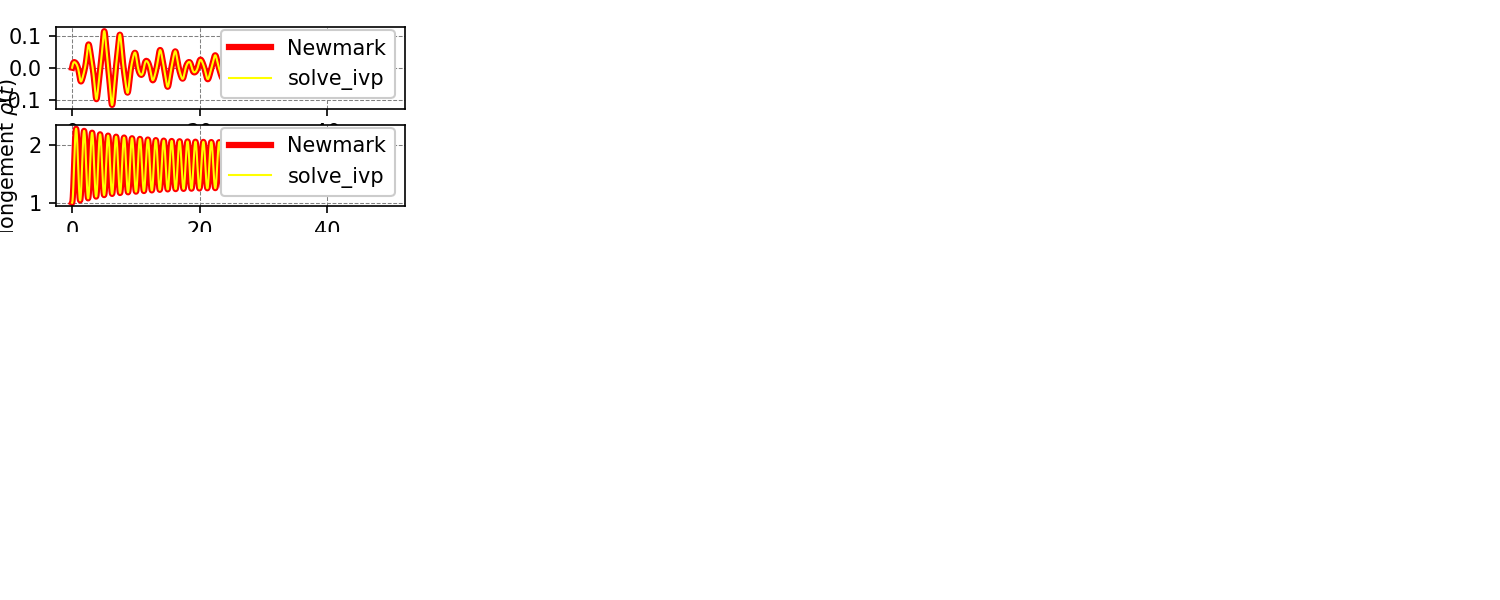

In [8]:
# plot sol Newmark
fig = plt.figure(figsize=(10, 4))  # Crée une figure de dimensions données.
ax = fig.add_subplot(2,1,1)
ax.plot(tt, Xt[:,1], color='red', linewidth = 3,label='Newmark')  # Trace theta en fonction du temps.
ax.set_xlabel("Temps")                 # titre axe horizontal
ax.set_ylabel(r"angle $\theta (t)$")   # titre axe vertical
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
# plot sol solve_ivp pour comparaison
ax.plot(sol.t, sol.y[0], color='yellow', linewidth = 1, label='solve_ivp')
ax.legend(loc='lower right',framealpha=1)  # ajout d une legende dans la coin inferieur droit

bx = fig.add_subplot(2,1,2)
bx.plot(tt, Xt[:,0], color='red', linewidth = 3,label='Newmark')  # Trace rho en fonction du temps.
bx.set_xlabel("Temps")                 # titre axe horizontal
bx.set_ylabel(r"allongement $\rho (t)$")  # titre axe vertical
bx.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
# plot sol solve_ivp pour comparaison
bx.plot(sol.t, sol.y[2], color='yellow', linewidth = 1, label='solve_ivp')
bx.legend(loc='lower right',framealpha=1)  # ajout d une legende dans la coin inferieur droit

plt.show()

---
<a id="Trajectoire"></a>
## Trajectoire du pendule et comparaison avec solve_ivp (schéma RK45) de Scipy
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

<IPython.core.display.Javascript object>


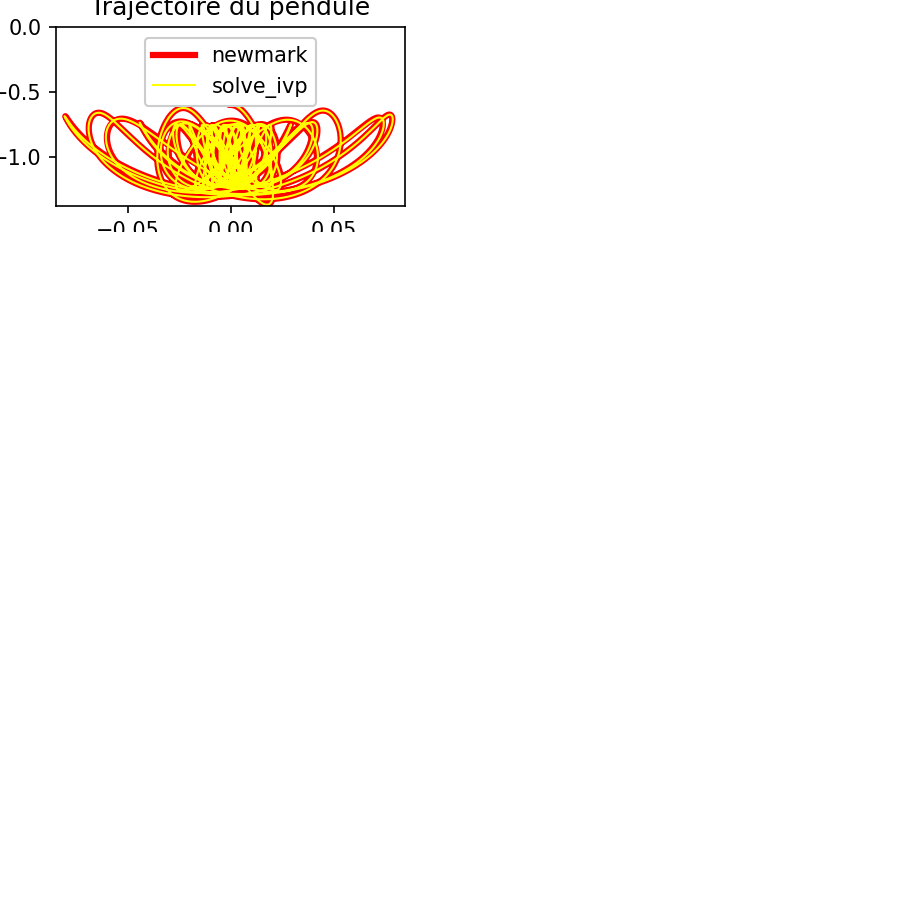

In [9]:
# Trajectoire solve_ivp
theta,dtheta,rho,drho=sol.y
l=rho*l0
dl=drho*l0
xh=l*np.sin(theta)
zv=l*np.cos(theta)
xmax=max(abs(xh))*1.05;zmax=max(zv)*1.01;
# Trajectoire Newmark
rhot,thetat=Xt.T
drhot,dthetat=dXt.T
lt=rhot*l0
dlt=drhot*l0
xht=lt*np.sin(thetat)
zvt=lt*np.cos(thetat)
# Plot Trajectoire 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(autoscale_on=False, xlim=(-xmax, xmax), ylim=(-zmax, 0.))
ax.set_title('Trajectoire du pendule')
ax.set_xlabel("x(t)")        # titre axe horizontal
ax.set_ylabel(r"y(t)")       # titre axe vertical
ax.plot(xht, -zvt, color='red', linewidth = 3, label='newmark')
ax.plot(xh, -zv, color='yellow', linewidth = 1, label='solve_ivp')
ax.legend(loc='upper center',framealpha=1)
plt.show()

---
<a id="Animation"></a>
## Animation et portraits de phase
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

In [10]:
# -------------------------
# durée de simulation = Np périodes de l'excitation avec Ni points d'intégration par période
# Np=15; Ni=100   # pour video
Np=800; Ni=100
NT=Np*Ni+1
# -------------------------
# amplitude de l'excitation
# a=0.0;
a=0.015;   # periodique
# a=0.0220;  # quasi-periodique
# a=0.039;   # chaotique
# a=0.041;   # quasi-periodique
# a=0.09;    # 2T-periodique en theta
# a=0.12;    # 2T-periodique en theta
# -------------------------
# positions et vitesses initiales
theta0=0.; dtheta0=0.1; rho0=1.; drho0=0.
X0=np.array([[rho0],[theta0]])
dX0=np.array([[drho0],[dtheta0]])
# -------------------------
# Integration par Newmark
start = time.process_time()
tt,Xt,dXt=Newmark(X0,dX0,t0,dt,NT)
print('ellapsed time: ',time.process_time() - start)


ellapsed time:  8.671875


<IPython.core.display.Javascript object>


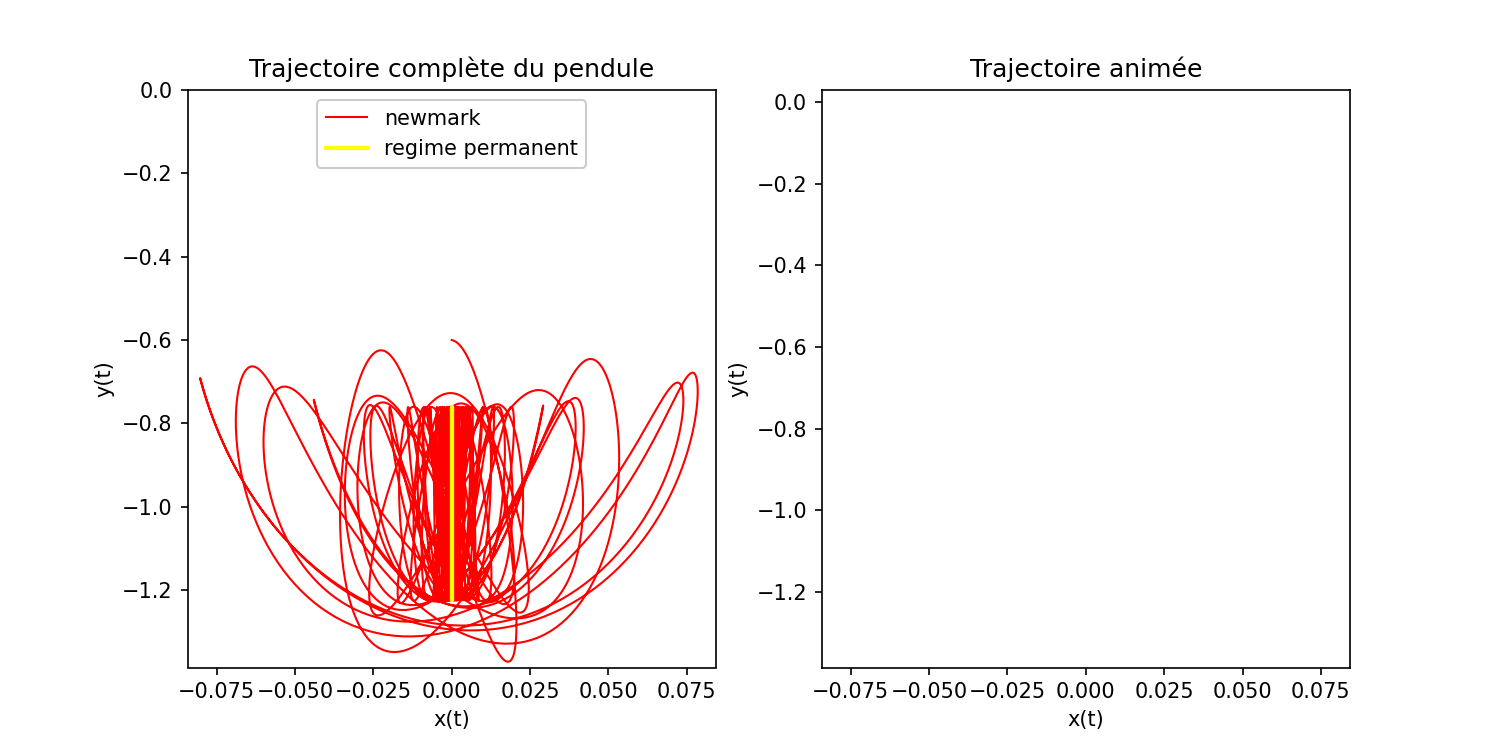

<IPython.core.display.Javascript object>


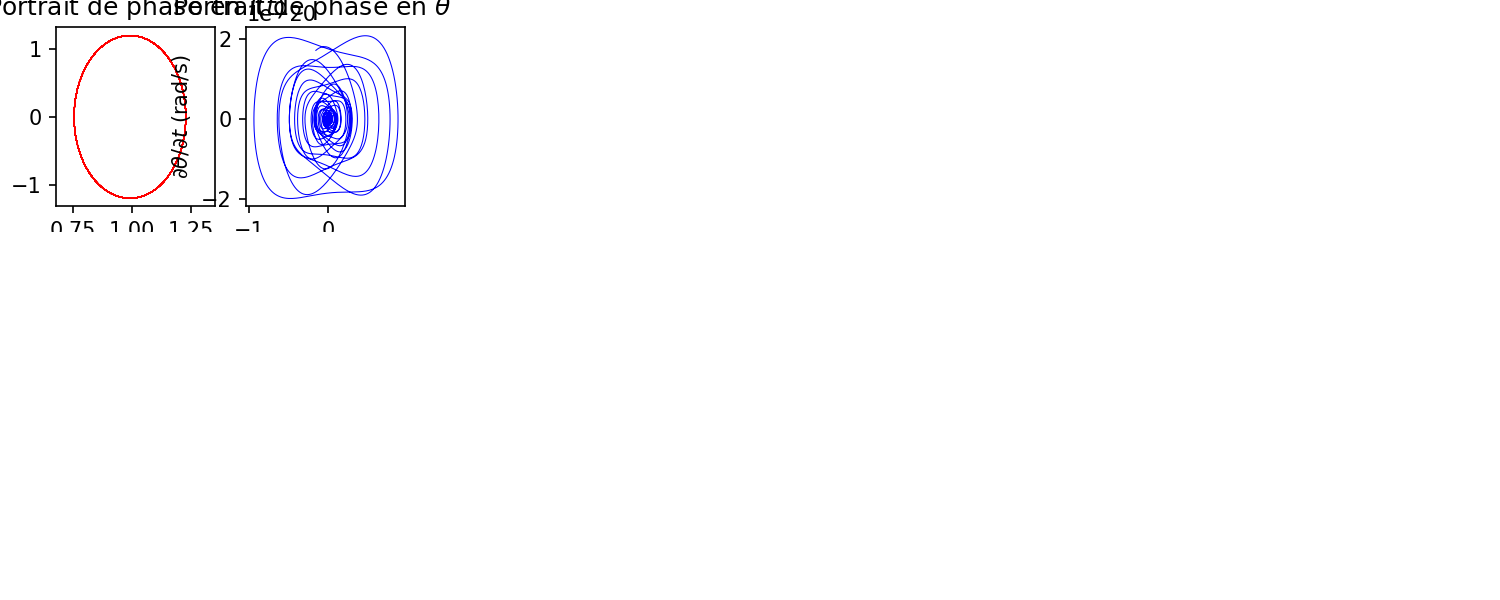

In [11]:
# -------------------------
# 1=oui  0=non
anim=1   # animation du pendule
# -------------------------
# Nplot périodes pour la trace fantome de l animation Nplot<Np
Nplot=2
if Nplot >= Np:    Nplot=Np
# Ns : periode d integration a partir de laquelle le régime transitoire est considéré terminé 
# Le portrait de phase est tracé à partir de cet instant
Ns=Np-100
# indice du pas de temps a partir duquel le régime transitoire est considéré terminé
Na=NT-(Np-Ns)*Ni+1;
# Trajectoire Newmark
rhot,thetat=Xt.T
drhot,dthetat=dXt.T
lt=rhot*l0
dlt=drhot*l0
xht=lt*np.sin(thetat)
zvt=lt*np.cos(thetat)
z0t=a*np.sin(omega*tt[:,0])
xmax=max(abs(xht))*1.05;zmax=max(zvt)*1.01;

# Plot Trajectoire 
fig1 = plt.figure(figsize=(10, 5))
ax = fig1.add_subplot(1,2,1,autoscale_on=False, xlim=(-xmax, xmax), ylim=(-zmax, 0.))
ax.set_title('Trajectoire complète du pendule')
ax.set_xlabel("x(t)")        # titre axe horizontal
ax.set_ylabel(r"y(t)")       # titre axe vertical
ax.plot(xht, -z0t-zvt, color='red', linewidth = 1, label='newmark')
ax.plot(xht[-Nplot*Ni:], -z0t[-Nplot*Ni:]-zvt[-Nplot*Ni:], color='yellow', linewidth = 2, label='regime permanent')
ax.legend(loc='upper center',framealpha=1)
plt.show()

# Animation (ne s execute que si anim=1)
if anim:
    bx = fig1.add_subplot(1,2,2,autoscale_on=False, xlim=(-xmax, xmax), ylim=(-zmax, 2*a))
    bx.set_title('Trajectoire animée')
    bx.set_xlabel("x(t)")        # titre axe horizontal
    bx.set_ylabel(r"y(t)")       # titre axe vertical
    # on dessine le pendule avec 2 points relies par une droite
    line, = bx.plot([], [], 'o-', c='black',lw=1, ms=7,mfc='red',mew=2,mec='black')
    trace, = bx.plot([], [], '-', c='magenta', lw=1)
    time_template = 'time = %.1fs'
    time_text = bx.text(0.05, 0.9, '', transform=bx.transAxes)

    def animate(i):
        # coordonnees du point pivot et de l extremite
        pivot = [0, xht[i]]
        extremite = [-z0t[i], -z0t[i]-zvt[i]]
        # trace fantome avec les Nplot dernieres periodes du mouvement
        if i < Nplot*Ni:
            trace_x=xht[0:i]
            trace_z=-z0t[0:i]-zvt[0:i]
        else:
            trace_x=xht[i-Nplot*Ni:i]
            trace_z=-z0t[i-Nplot*Ni:i]-zvt[i-Nplot*Ni:i]
        # mise a jour du pendule et de sa trace
        line.set_data(pivot, extremite)
        trace.set_data(trace_x, trace_z)
        time_text.set_text(time_template % (i*dt))
        return line, trace, time_text

    anim = animation.FuncAnimation(
        fig=fig1, func=animate, frames=len(xht), interval=dt*100, blit=True, repeat=False)

# Portaits de phase
fig2 = plt.figure(figsize=(10, 4))
cx = fig2.add_subplot(1,2,1,autoscale_on=False, 
     xlim=(0.9*min(lt[Na:NT]),1.1*max(lt[Na:NT])),ylim=(1.1*min(dlt[Na:NT]),1.1*max(dlt[Na:NT])))
cx.set_title(r'Portrait de phase en $l(t)$')
cx.set_xlabel(r"$l(t) (m)$")            # titre axe horizontal
cx.set_ylabel(r"$\partial l /\partial t$ (m/s)")       # titre axe vertical
cx.plot(lt[Na:NT],dlt[Na:NT], color='red', linewidth = 0.5)
dx = fig2.add_subplot(1,2,2,autoscale_on=False, 
     xlim=(1.1*min(thetat[Na:NT]),1.1*max(thetat[Na:NT])),ylim=(1.1*min(dthetat[Na:NT]),1.1*max(dthetat[Na:NT])))
dx.set_title(r'Portrait de phase en $\theta(t)$')
dx.set_xlabel(r"$\theta(t) (rad)$")       # titre axe horizontal
dx.set_ylabel(r"$\partial \theta /\partial t$ (rad/s)")  # titre axe vertical
dx.plot(thetat[Na:NT],dthetat[Na:NT], color='blue', linewidth = 0.5)
plt.show()

# Pour generer une anim avec des boutons de controle
# from IPython.display import HTML
# HTML(anim.to_jshtml())


---
<a id="Poincare"></a>
## Sections de Poincaré
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

<IPython.core.display.Javascript object>


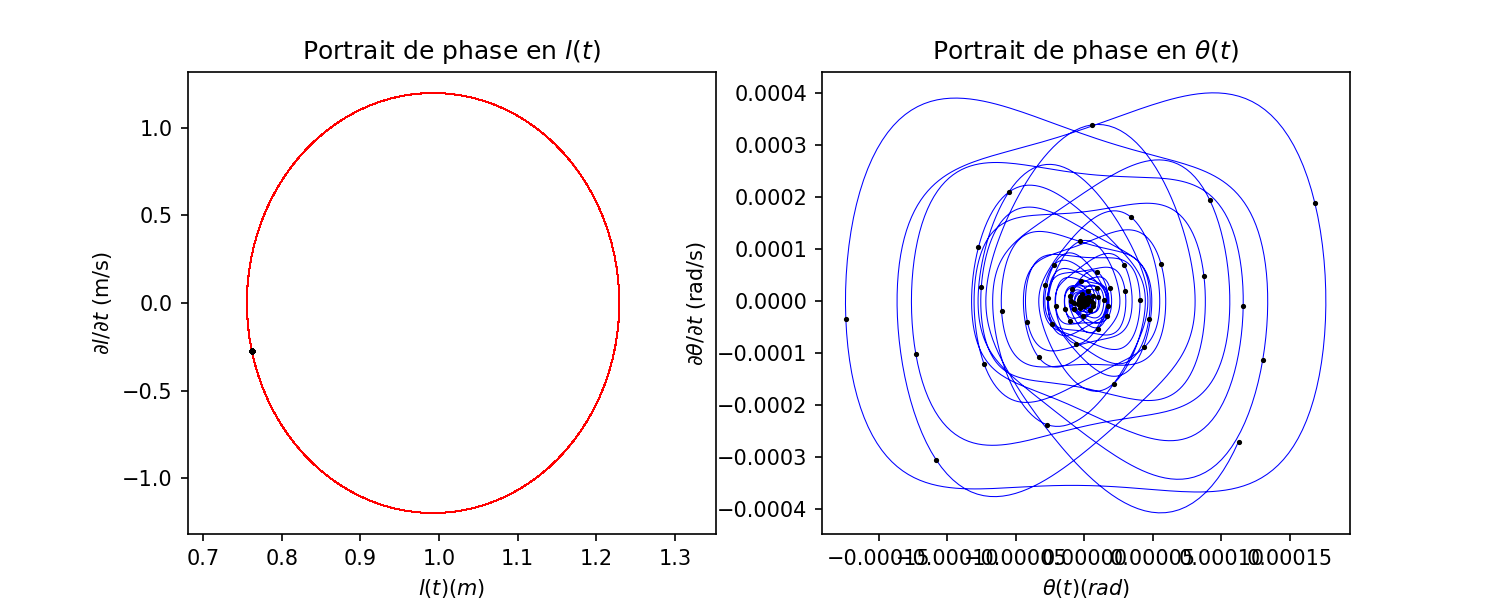

<IPython.core.display.Javascript object>


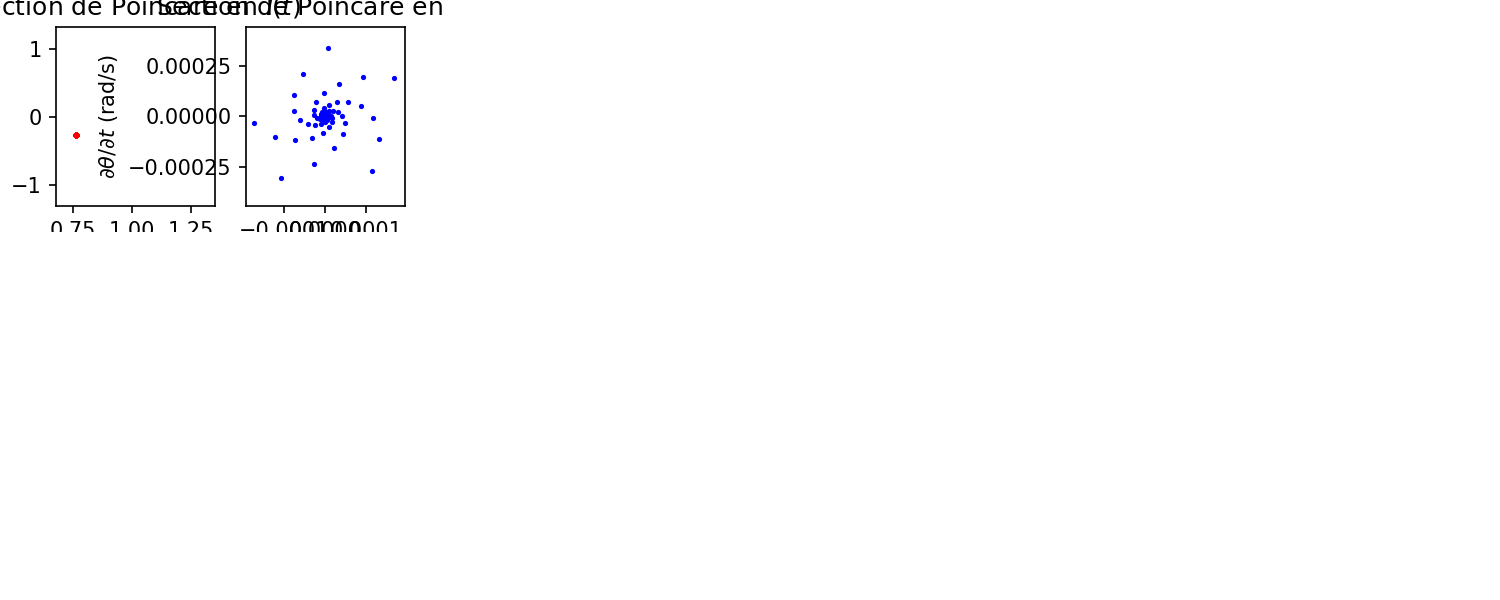

In [12]:
# Ns : periode d integration à partir de laquelle le régime transitoire est considéré terminé
# La solution est prise en compte dans la section de Poincaré à partir de cet instant
Ns=100
if Ns >= Np:    Ns=Np-1
# indice du pas de temps a partir duquel le régime transitoire est considéré terminé
Na=NT-(Np-Ns)*Ni+1;

# Portaits de phase
fig2 = plt.figure(figsize=(10, 4))
cx = fig2.add_subplot(1,2,1,autoscale_on=False, 
     xlim=(0.9*min(lt[Na:NT]),1.1*max(lt[Na:NT])),ylim=(1.1*min(dlt[Na:NT]),1.1*max(dlt[Na:NT])))
cx.set_title(r'Portrait de phase en $l(t)$')
cx.set_xlabel(r"$l(t) (m)$")            # titre axe horizontal
cx.set_ylabel(r"$\partial l /\partial t$ (m/s)")       # titre axe vertical
cx.plot(lt[Na:NT],dlt[Na:NT], color='red', linewidth = 0.5)
dx = fig2.add_subplot(1,2,2,autoscale_on=False, 
     xlim=(1.1*min(thetat[Na:NT]),1.1*max(thetat[Na:NT])),ylim=(1.1*min(dthetat[Na:NT]),1.1*max(dthetat[Na:NT])))
dx.set_title(r'Portrait de phase en $\theta(t)$')
dx.set_xlabel(r"$\theta(t) (rad)$")       # titre axe horizontal
dx.set_ylabel(r"$\partial \theta /\partial t$ (rad/s)")  # titre axe vertical
dx.plot(thetat[Na:NT],dthetat[Na:NT], color='blue', linewidth = 0.5)

# Sections de Poincare
# Echantillonnage tous les Ni points des Ns derniere periodes
lp=lt[Na:NT:Ni];
dlp=dlt[Na:NT:Ni];
thetap=thetat[Na:NT:Ni];
dthetap=dthetat[Na:NT:Ni];
cx.plot(lp,dlp, '.k', ms=3)
dx.plot(thetap,dthetap, '.k', ms=3)

fig3 = plt.figure(figsize=(10, 4))
ex = fig3.add_subplot(1,2,1,autoscale_on=False, 
     xlim=(0.9*min(lt[Na:NT]),1.1*max(lt[Na:NT])),ylim=(1.1*min(dlt[Na:NT]),1.1*max(dlt[Na:NT])))
ex.set_title(r'Section de Poincaré en $l(t)$')
ex.set_xlabel(r"$l(t) (m)$")            # titre axe horizontal
ex.set_ylabel(r"$\partial l /\partial t$ (m/s)")       # titre axe vertical
ex.plot(lp,dlp, '.r', ms=3)
fx = fig3.add_subplot(1,2,2,autoscale_on=False, 
     xlim=(1.1*min(thetat[Na:NT]),1.1*max(thetat[Na:NT])),ylim=(1.1*min(dthetat[Na:NT]),1.1*max(dthetat[Na:NT])))
fx.set_title(r'Section de Poincaré en $\theta(t)$')
fx.set_xlabel(r"$\theta(t) (rad)$")       # titre axe horizontal
fx.set_ylabel(r"$\partial \theta /\partial t$ (rad/s)")  # titre axe vertical
fx.plot(thetap,dthetap, '.b', ms=3)
plt.show()


---
<a id="Diagramme"></a>
## Diagramme de bifurcation
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

<IPython.core.display.Javascript object>


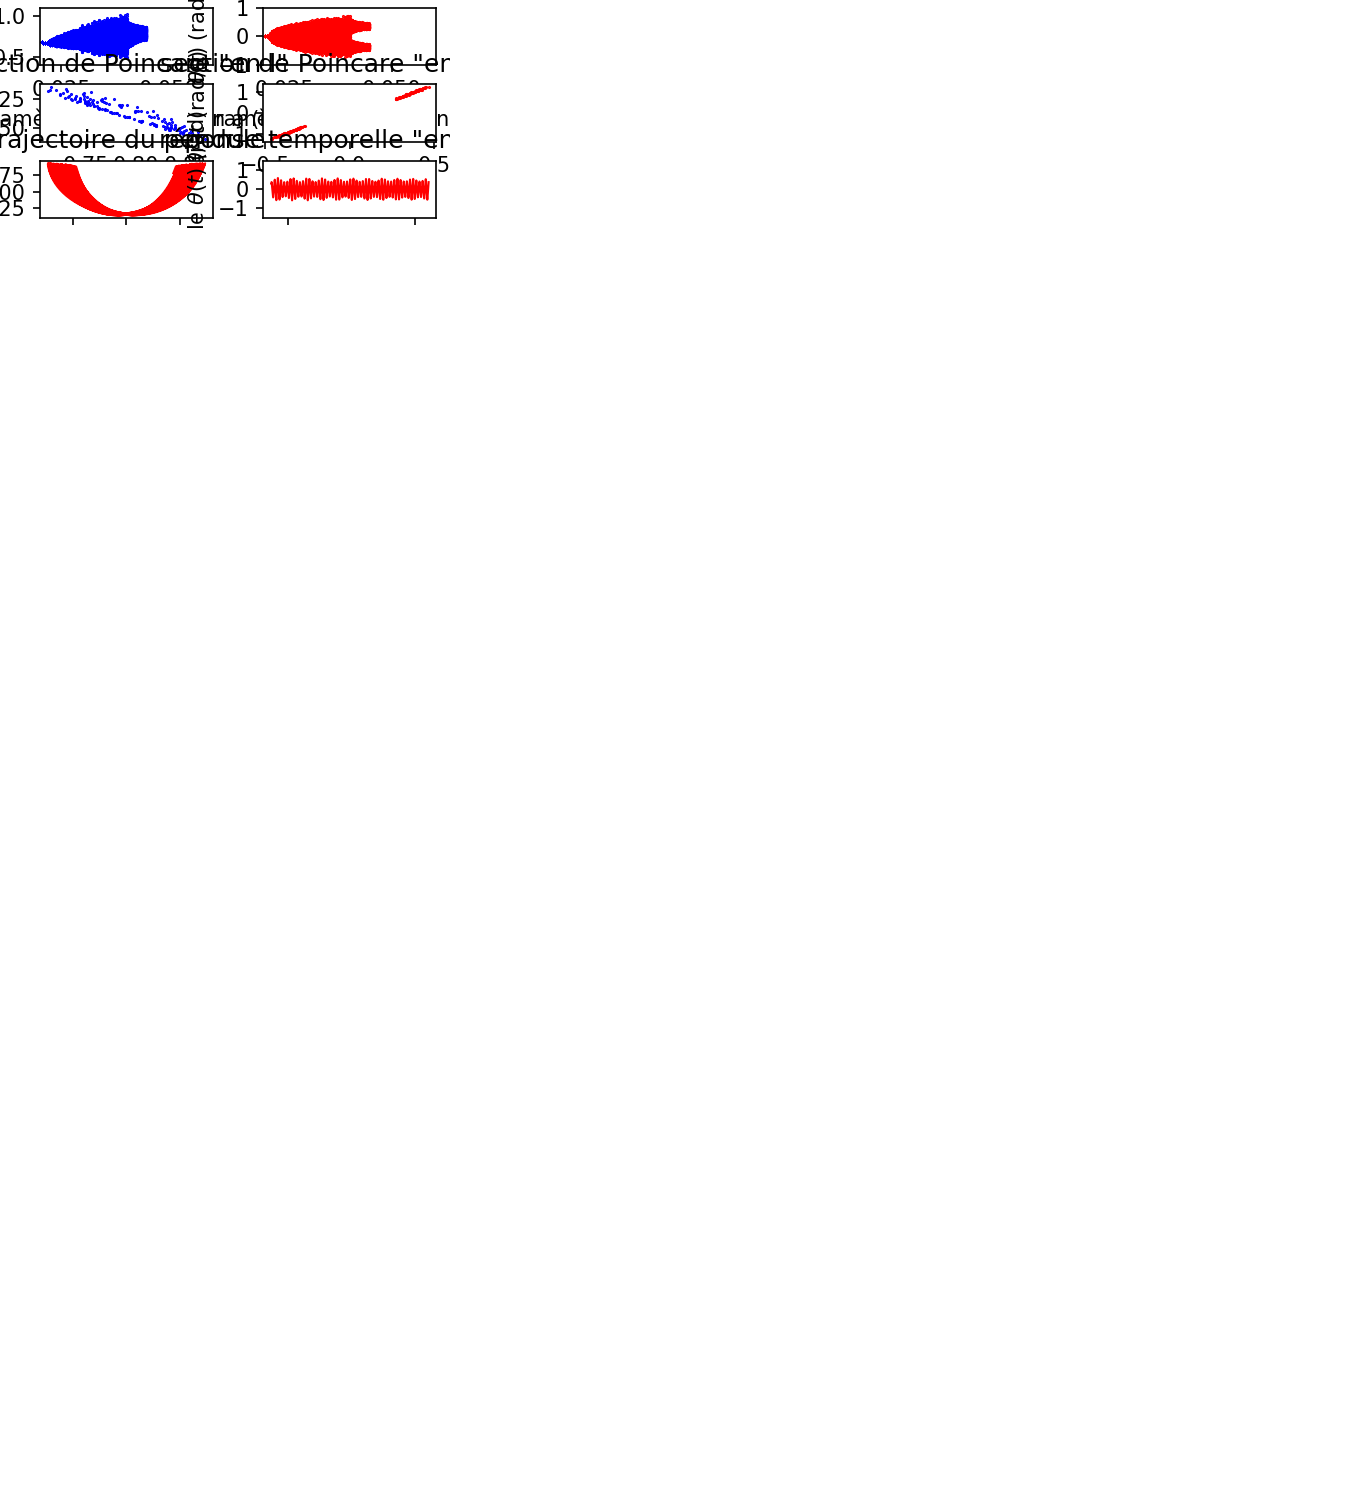

KeyboardInterrupt: 

In [13]:
# Diagramme de bifurcation
# -------------------------
# amplitude initiale, finale et increment d'amplitude pour les diagrammes de bifurcation
# ne nombre de points d'incrementation de l'amplitude
#ai=0.01; af=0.1; ne=200; da=(af-ai)/(ne-1) 
ai=0.02; af=0.06; ne=100; da=(af-ai)/(ne-1) 
# ai=0.01; af=0.15; ne=300; da=(af-ai)/(ne-1)
# ai=0.0215; af=0.0220; ne=30; da=(af-ai)/(ne-1) % init quasi-periodique
# ai=0.0210; af=0.0215; ne=10; da=(af-ai)/(ne-1) % init theta 2T
a=ai
# -------------------------
# positions et vitesses initiales
theta0=0.; dtheta0=0.1; rho0=1.; drho0=0.
X0=np.array([[rho0],[theta0]])
dX0=np.array([[drho0],[dtheta0]])
# -------------------------
# Durée de simulation : Np périodes de l'excitation avec Ni points d'intégration par période
#Np=1100 ; Ni=300 ; NT=Np*Ni+1
Np=250 ; Ni=100 ; NT=Np*Ni+1
# Ns : periode d integration à partir de laquelle le régime transitoire est considéré terminé
#      La solution est prise en compte dans la section de Poincaré à partir de cet instant
# Na : indice du pas de temps a partir duquel le régime transitoire est considéré terminé
# Nth nombre de periodes de tracé de la reponse temporelle en theta
Ns=100 ; Na=NT-(Np-Ns)*Ni+1
Nth=100 ; Ntha=NT-Nth*Ni+1

fig = plt.figure(figsize=(9, 10));
#
ax = fig.add_subplot(3,2,1,autoscale_on=False, xlim=(ai,ai+ne*da), ylim=(0.4,1.1));
ax.set_xlabel('paramètre de bifurcation a (m)')
ax.set_ylabel(r'$l(t)$ (m)')
ax.set_title('diagramme de bifurcation "en l"')
#
bx = fig.add_subplot(3,2,2,autoscale_on=False, xlim=(ai,ai+ne*da), ylim=(-1.,1.));
bx.set_xlabel('paramètre de bifurcation a (m)')
bx.set_ylabel(r'$\theta(t)$ (rad)')
bx.set_title('diagramme de bifurcation "en theta"')
#
cx = fig.add_subplot(3,2,3);
cx.set_xlabel('l (m)')
cx.set_ylabel(r'$\partial l /\partial t$ (m/s)')
cx.set_title('section de Poincaré "en l"')
#
dx = fig.add_subplot(3,2,4);
dx.set_xlabel(r'$\theta$ (rad)')
dx.set_ylabel(r'$\partial \theta /\partial t$ (rad/s)')
dx.set_title('section de Poincaré "en theta"')
#
ex = fig.add_subplot(3,2,5);
ex.set_ylim([0,2.])
ex.set_xlabel(r'$t$ (s)')
ex.set_ylabel(r'longueur $l(t)$ (m)')
ex.set_title('réponse temporelle "en l"')
#
fx = fig.add_subplot(3,2,6);
fx.set_ylim([-1.5,1.5])
fx.set_xlabel(r'$t$ (s)')
fx.set_ylabel(r'angle $\theta(t)$ (rad)')
fx.set_title('réponse temporelle "en theta"')
fig.tight_layout()
fig.canvas.draw()

for i in range(1,ne):
    # incrementation de a
    a=a+da;
    # integration des equations de mouvement
    tt,Xt,dXt=Newmark(X0,dX0,t0,dt,NT)
    rhot,thetat=Xt.T
    drhot,dthetat=dXt.T
    # longueur et position du pendule
    lt=rhot*l0
    dlt=drhot*l0
    xht=lt*np.sin(thetat)
    zvt=lt*np.cos(thetat)
    # Construction des sections de Poincare par échantillonnage tous les Ni points des Ns derniere periodes
    lp=lt[Na:NT:Ni]
    dlp=dlt[Na:NT:Ni]
    thetap=thetat[Na:NT:Ni]
    dthetap=dthetat[Na:NT:Ni]
    tp=tt[Na:NT:Ni]
    amp=np.full((len(lp), 1), a) # vecteur de meme taille que lp rempli avec la valeur a
    ax.plot(amp,lp, 'b.', ms=1)
    bx.plot(amp,thetap, 'r.', ms=1)
    cx.cla();dx.cla()  # efface les 2 subplots
    cx.set_xlabel('l (m)')
    cx.set_ylabel(r'$\partial l /\partial t$ (m/s)')
    cx.set_title('section de Poincare "en l"')
    cx.plot(lp,dlp, 'b.', ms=1)
    dx.set_xlabel(r'$\theta$ (rad)')
    dx.set_ylabel(r'$\partial \theta /\partial t$ (rad/s)')
    dx.set_title('section de Poincare "en theta"')
    dx.plot(thetap,dthetap, 'r.', ms=1)
    ex.cla();fx.cla()  # efface les 2 subplots
    ex.set_xlabel("x(t)")
    ex.set_ylabel(r"y(t)")
    ex.set_title('trajectoire du pendule')
    ex.plot(xht[Ntha:NT], -z0t[Ntha:NT]-zvt[Ntha:NT], 'r-', lw=1)
    fx.set_ylim([-1.5,1.5])
    fx.set_xlabel(r'$t$ (s)')
    fx.set_ylabel(r'angle $\theta(t)$ (rad)')
    fx.set_title('réponse temporelle "en theta"')
    fx.plot(tt[Ntha:NT],thetat[Ntha:NT], 'r-', lw=1)
    fig.tight_layout()
    fig.canvas.draw()